In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import STL

sns.set_theme()

STORE_ID = 'STORE_1'

# Данные по первому магазину

Файл: shop_sales_dates.csv

- date: дата в формате «y-m-d»

- wm_yr_wk: идентификатор недели, к которой относится дата

- weekday: день недели (суббота, воскресенье, ..., пятница)

- wday: идентификатор дня недели, начиная с субботы

- month: месяц даты

- year: год даты

- event_name_1: если дата включает событие, название этого события

- event_type_1: если дата включает событие, тип этого события

- event_name_2: если дата включает второе событие, название этого события

- event_type_2: если дата включает второе событие, тип этого события

- date_id: идентификатор даты

In [2]:
dates = pd.read_csv('../data/shop_sales_dates.csv')  # даты и праздники
dates['date'] = pd.to_datetime(dates['date'])
dates.tail()

,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,date_id,CASHBACK_STORE_1,CASHBACK_STORE_2,CASHBACK_STORE_3
1814,2016-01-17,11551,Sunday,2,1,2016,NaN,NaN,NaN,NaN,1815,0,0,0
1815,2016-01-18,11551,Monday,3,1,2016,MartinLutherKingDay,National,NaN,NaN,1816,0,0,0
1816,2016-01-19,11551,Tuesday,4,1,2016,NaN,NaN,NaN,NaN,1817,0,0,0
1817,2016-01-20,11551,Wednesday,5,1,2016,NaN,NaN,NaN,NaN,1818,0,0,0
1818,2016-01-21,11551,Thursday,6,1,2016,NaN,NaN,NaN,NaN,1819,0,0,0


In [3]:
print('event_name_1\n', dates['event_name_1'].unique(), '\n')
print('event_type_1\n', dates['event_type_1'].unique(), '\n')
print('event_name_2\n', dates['event_name_2'].unique(), '\n')
print('event_type_2\n', dates['event_type_2'].unique(), '\n')

event_name_1
 [nan 'SuperBowl' 'ValentinesDay' 'PresidentsDay' 'LentStart' 'LentWeek2'
 'StPatricksDay' 'Purim End' 'OrthodoxEaster' 'Pesach End' 'Cinco De Mayo'
 "Mother's day" 'MemorialDay' 'NBAFinalsStart' 'NBAFinalsEnd'
 "Father's day" 'IndependenceDay' 'Ramadan starts' 'Eid al-Fitr'
 'LaborDay' 'ColumbusDay' 'Halloween' 'EidAlAdha' 'VeteransDay'
 'Thanksgiving' 'Christmas' 'Chanukah End' 'NewYear' 'OrthodoxChristmas'
 'MartinLutherKingDay' 'Easter'] 

event_type_1
 [nan 'Sporting' 'Cultural' 'National' 'Religious'] 

event_name_2
 [nan 'Easter' 'Cinco De Mayo' 'OrthodoxEaster' "Father's day"] 

event_type_2
 [nan 'Cultural' 'Religious'] 



In [4]:
dates['event_name_1'] = dates['event_name_1'].combine_first(dates['event_name_2'])
dates = pd.get_dummies(dates, columns=['event_type_1'], prefix='type', dtype=int)
# оставляем только event_type, т.к. видов праздников многовато

dates['is_weekend'] = dates['wday'].apply(lambda x: 1 if x < 3 else 0)
# отдельно закодируем выходные дни

dates = dates.drop(
    columns=[
        'event_name_1',
        'event_name_2',
        'event_type_2',
        'CASHBACK_STORE_2',
        'CASHBACK_STORE_3',
    ]
)
dates.tail()

,date,wm_yr_wk,weekday,wday,month,year,date_id,CASHBACK_STORE_1,type_Cultural,type_National,type_Religious,type_Sporting,is_weekend
1814,2016-01-17,11551,Sunday,2,1,2016,1815,0,0,0,0,0,1
1815,2016-01-18,11551,Monday,3,1,2016,1816,0,0,1,0,0,0
1816,2016-01-19,11551,Tuesday,4,1,2016,1817,0,0,0,0,0,0
1817,2016-01-20,11551,Wednesday,5,1,2016,1818,0,0,0,0,0,0
1818,2016-01-21,11551,Thursday,6,1,2016,1819,0,0,0,0,0,0


Файл: shop_sales_prices.csv

- store_id: идентификатор магазина, в котором продается товар

- item_id: идентификатор товара

- wm_yr_wk: идентификатор недели

- sell_price: цена товара для данной недели/магазина за неделю

In [5]:
prices = pd.read_csv('../data/shop_sales_prices.csv')
prices = prices[prices['store_id'] == STORE_ID]
prices.tail()  # средняя стоимость товаров еженедельно

,store_id,item_id,wm_yr_wk,sell_price
11136,STORE_1,STORE_1_584,11551,1.00
11137,STORE_1,STORE_1_586,11551,1.68
11138,STORE_1,STORE_1_587,11551,2.48
11139,STORE_1,STORE_1_714,11551,1.58
11140,STORE_1,STORE_1_727,11551,4.48


In [6]:
prices['item_id'].value_counts().to_frame()  # у одного товара меньше записей

,count
item_id,
STORE_1_064,260
STORE_1_065,260
STORE_1_376,260
STORE_1_090,260
STORE_1_252,260
STORE_1_339,260
STORE_1_546,260
STORE_1_547,260
STORE_1_555,260


Файл: shop_sales.csv

- item_id: идентификатор товара

- store_id: идентификатор магазина, в котором продается товар

- date_id: идентификатор даты

- cnt: количество единиц, проданных в день i

In [7]:
sales = pd.read_csv('../data/shop_sales.csv')
sales = sales[sales['store_id'] == STORE_ID]
sales.tail()  # количество продаж артикулов

,item_id,store_id,date_id,cnt
81850,STORE_1_727,STORE_1,1815,2
81851,STORE_1_727,STORE_1,1816,3
81852,STORE_1_727,STORE_1,1817,1
81853,STORE_1_727,STORE_1,1818,4
81854,STORE_1_727,STORE_1,1819,2


In [8]:
df = (
    dates.merge(sales, on='date_id')
    .merge(prices, on=['item_id', 'store_id', 'wm_yr_wk'], how='left')
    .sort_values(by='date')
)
df = df.drop(columns=['wm_yr_wk', 'weekday', 'store_id', 'date_id'])
df.tail()

,date,wday,month,year,CASHBACK_STORE_1,type_Cultural,type_National,type_Religious,type_Sporting,is_weekend,item_id,cnt,sell_price
27271,2016-01-21,6,1,2016,0,0,0,0,0,0,STORE_1_065,1,3.54
27270,2016-01-21,6,1,2016,0,0,0,0,0,0,STORE_1_064,0,2.68
27283,2016-01-21,6,1,2016,0,0,0,0,0,0,STORE_1_714,15,1.58
27276,2016-01-21,6,1,2016,0,0,0,0,0,0,STORE_1_339,6,0.80
27284,2016-01-21,6,1,2016,0,0,0,0,0,0,STORE_1_727,2,4.48


In [9]:
df.to_csv('../data/shop_sales_all.csv', index=False)

# Визуализация временных рядов

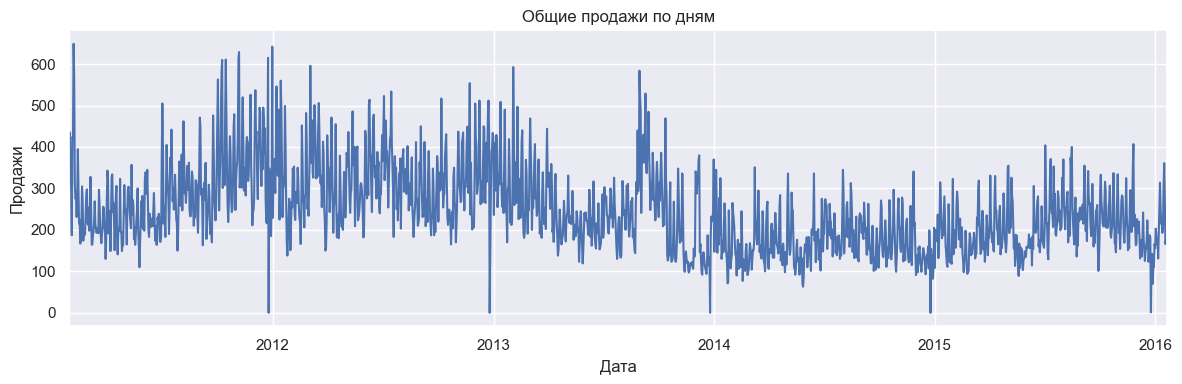

In [10]:
agg_by_day = df.groupby('date')['cnt'].sum()

plt.figure(figsize=(12, 4))
agg_by_day.plot()
plt.title('Общие продажи по дням')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.tight_layout()
plt.show()

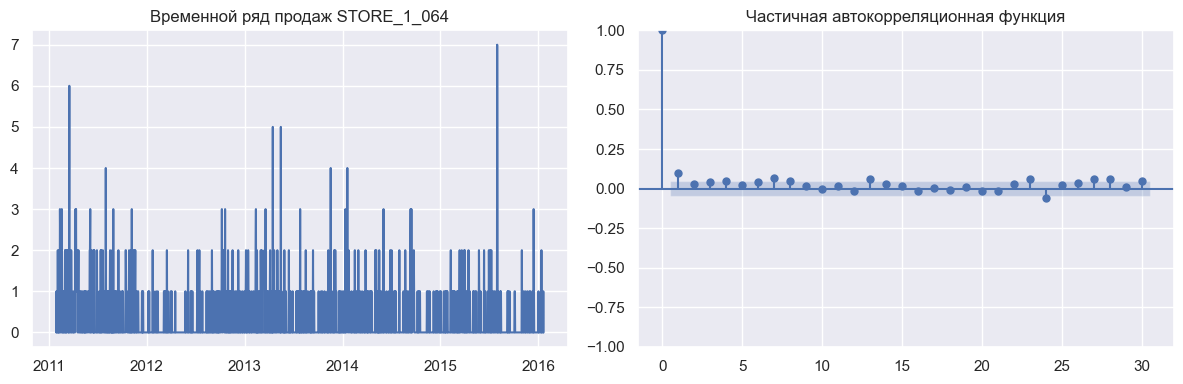

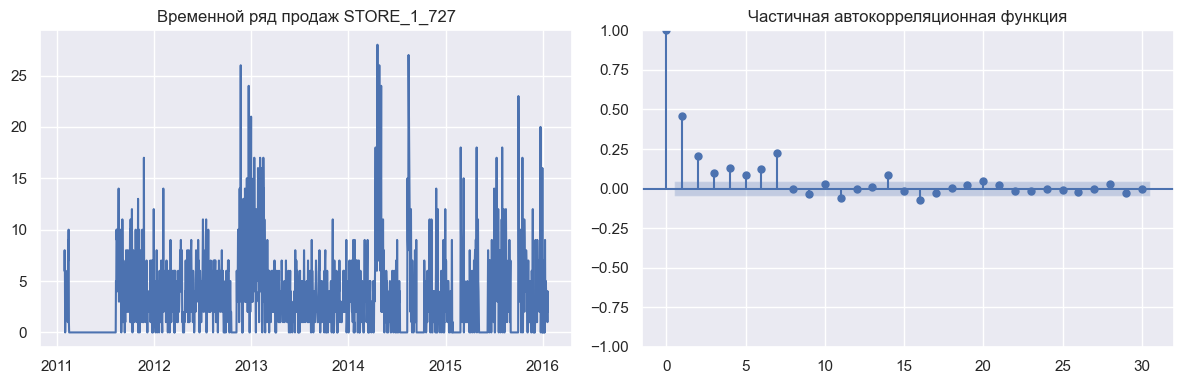

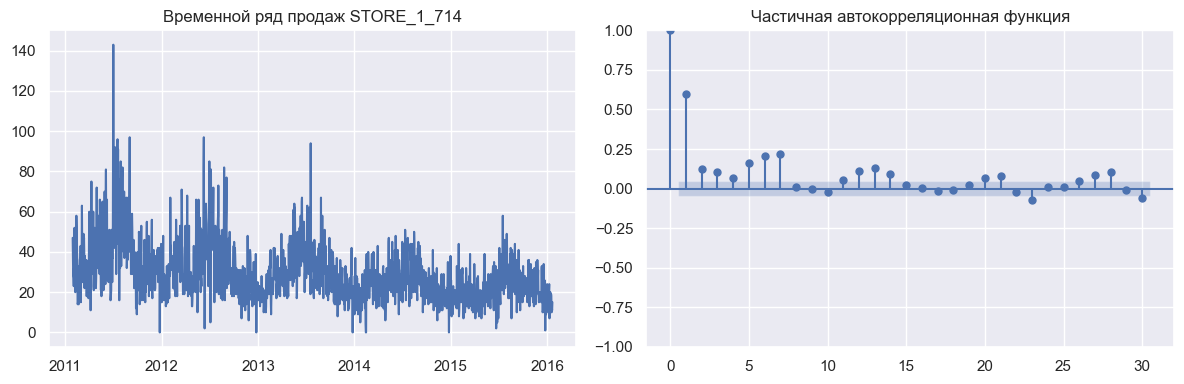

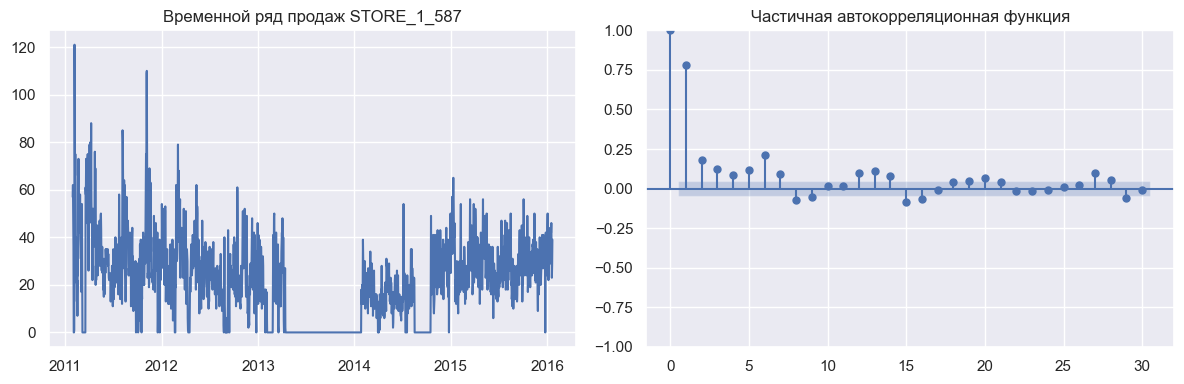

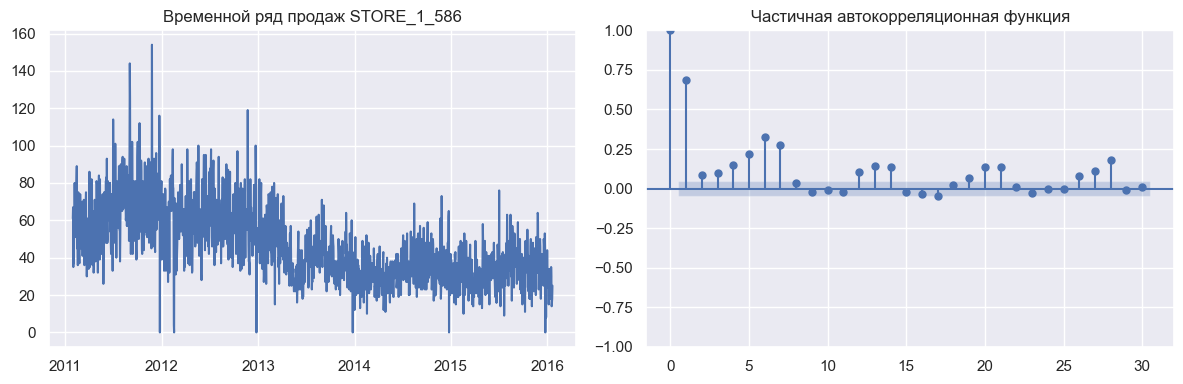

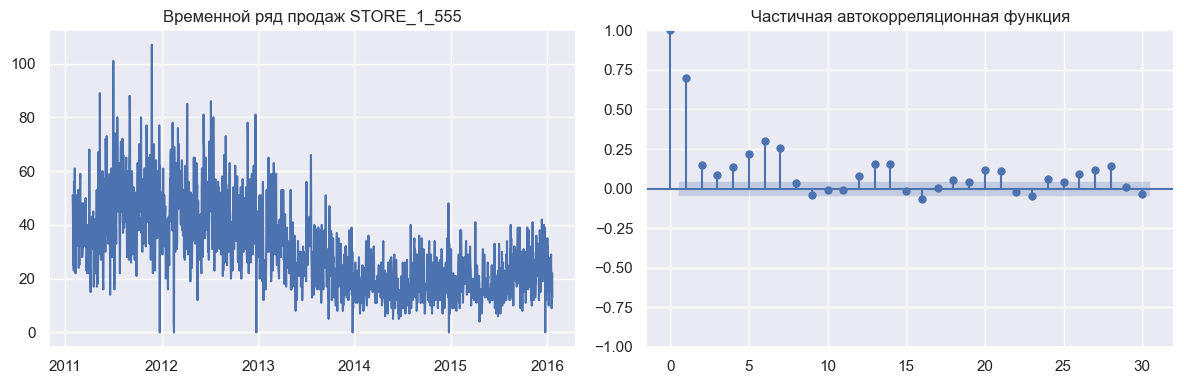

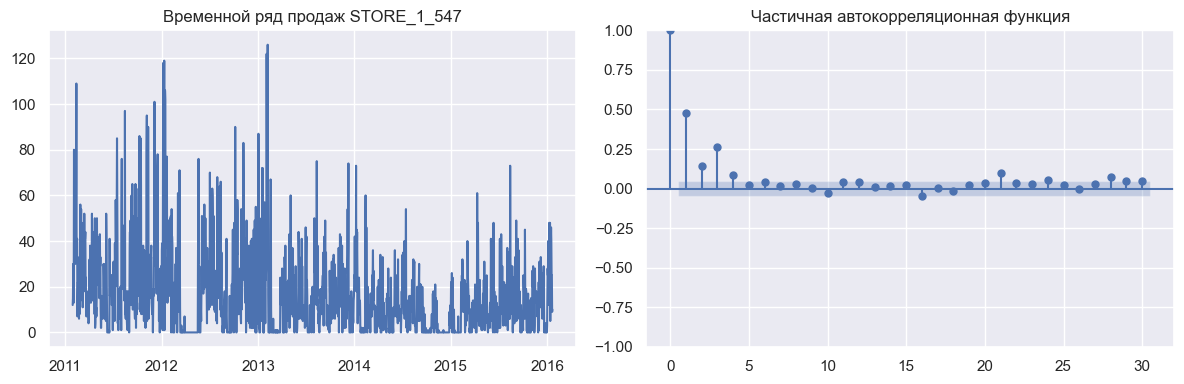

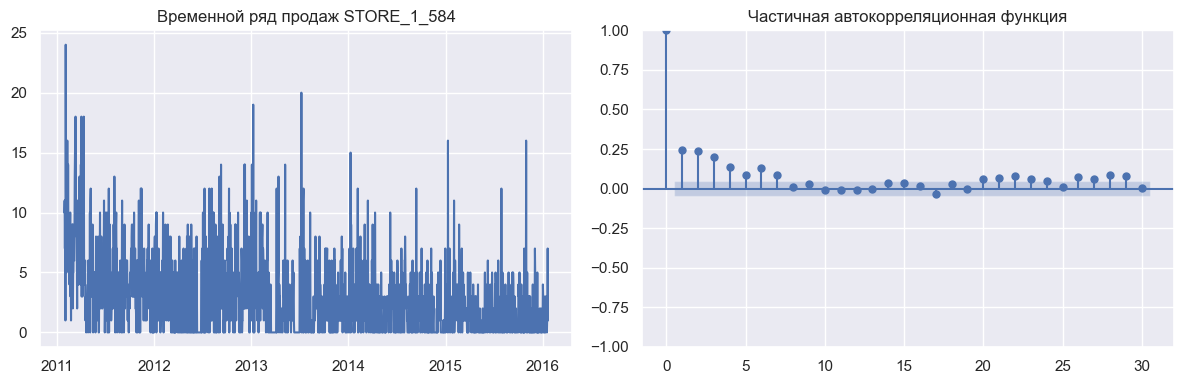

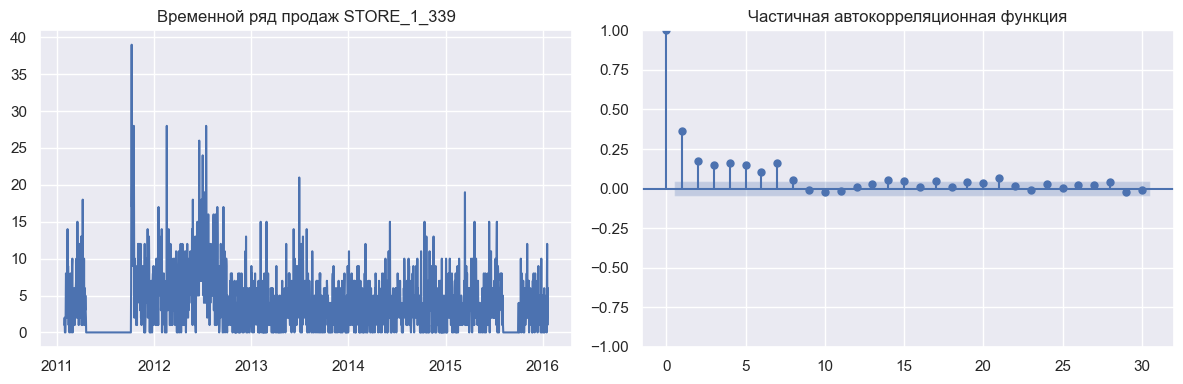

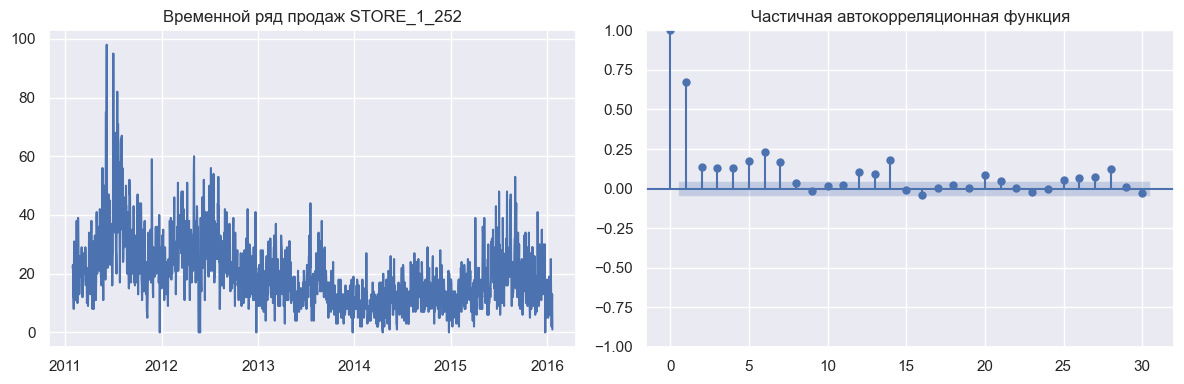

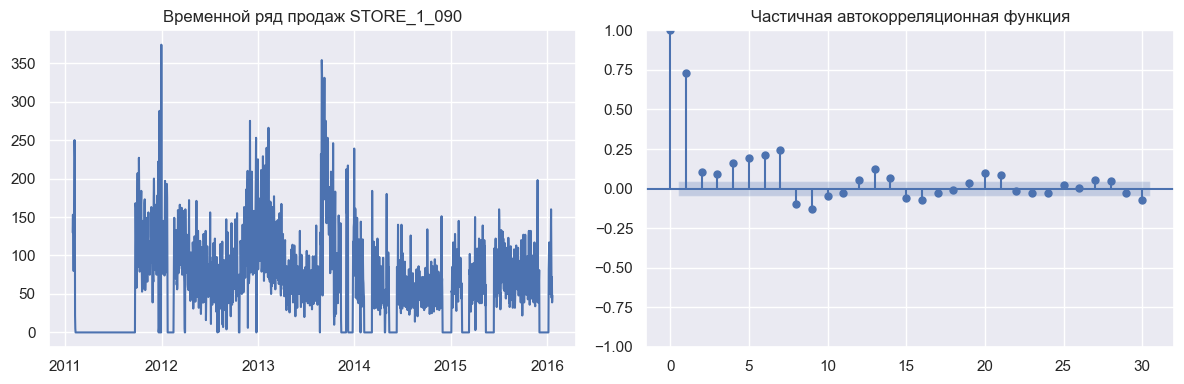

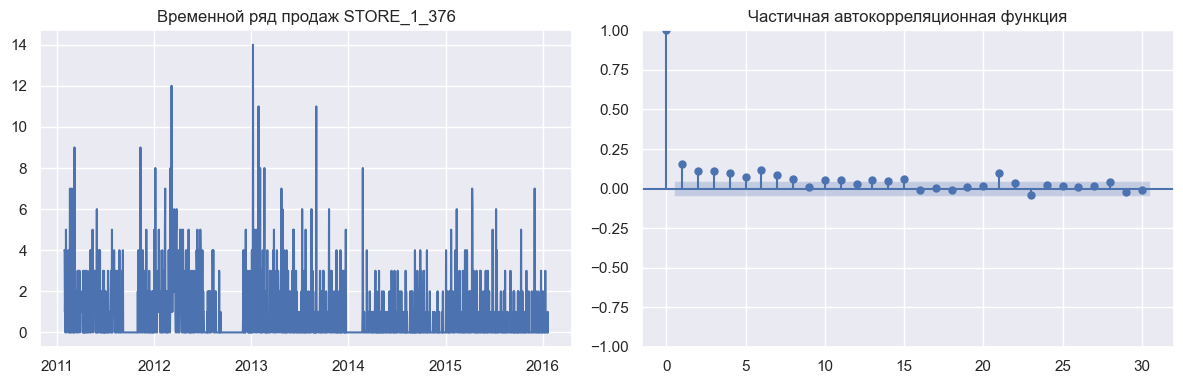

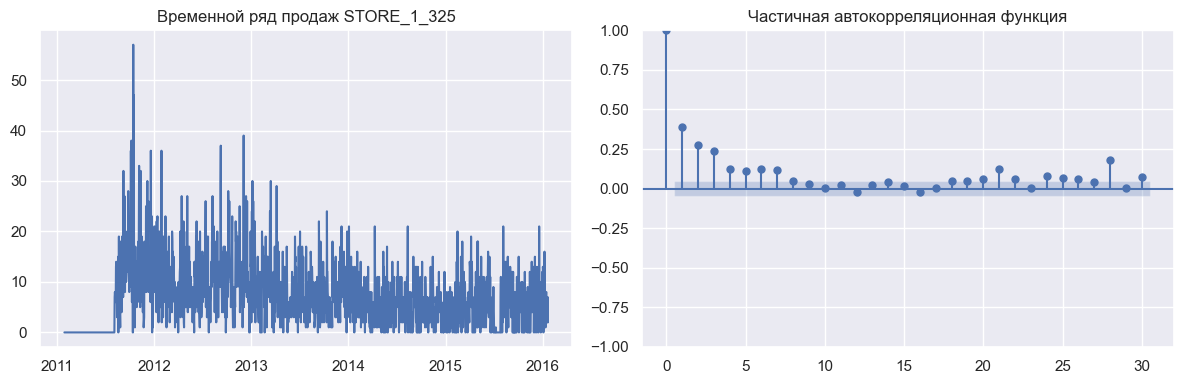

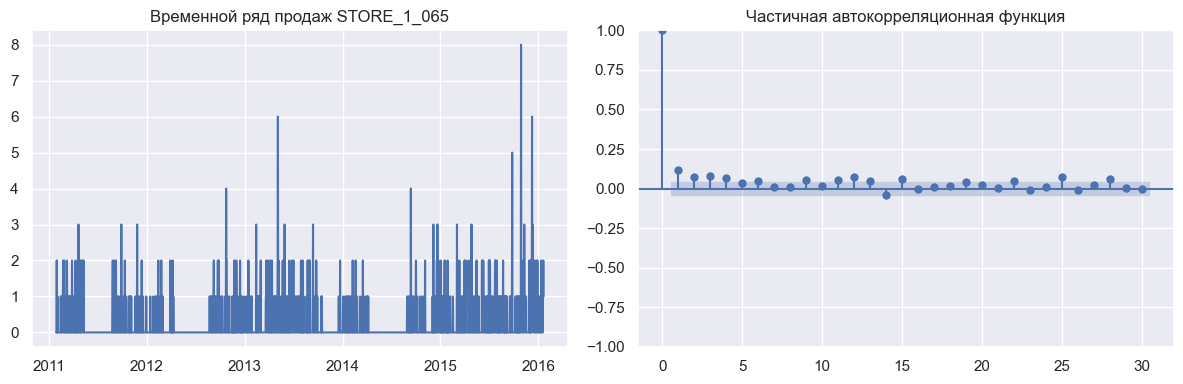

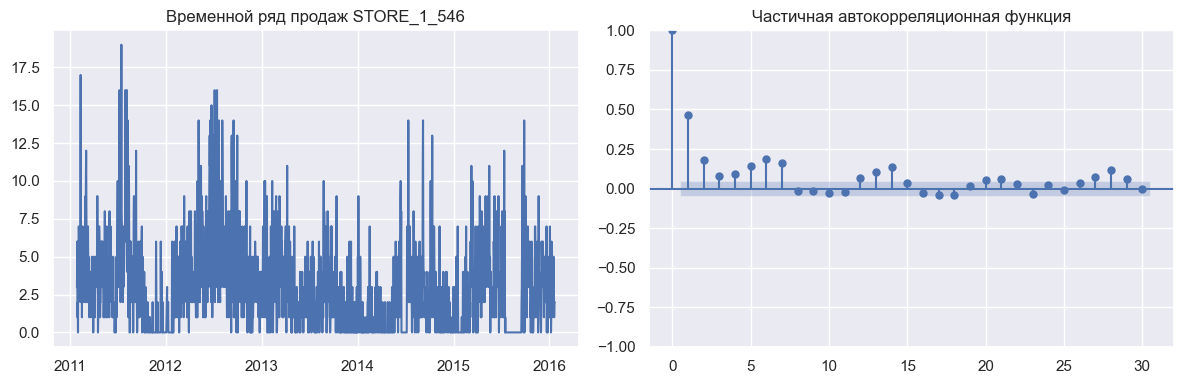

In [11]:
def plot_ts_pacf(series, item_id, pacf_lags=30) -> None:
    # визуализация ряда и ЧАКФ
    _, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(series['date'], series['cnt'])
    axes[0].set_title(f'Временной ряд продаж {item_id}')

    plot_pacf(series['cnt'], lags=pacf_lags, ax=axes[1])
    axes[1].set_title('Частичная автокорреляционная функция')

    plt.tight_layout()
    plt.show()


for art in df['item_id'].unique():
    df_art = df[(df['item_id'] == art)]
    plot_ts_pacf(df_art, art, pacf_lags=30)

# Маленький EDA

In [12]:
df['year'].value_counts().to_frame().sort_index()
# число записей о продажах отличается в первые и последний года

,count
year,
2011,5055
2012,5490
2013,5475
2014,5475
2015,5475
2016,315


In [13]:
df['item_id'].value_counts().to_frame().sort_values(by='count')
# число записей о продаже артикулов

,count
item_id,
STORE_1_064,1819
STORE_1_727,1819
STORE_1_714,1819
STORE_1_587,1819
STORE_1_586,1819
STORE_1_555,1819
STORE_1_547,1819
STORE_1_584,1819
STORE_1_339,1819


In [14]:
print('Всего записей:', df.shape[0])
print('Пустых значений в:')
print(' - cnt:', sum(df['cnt'].isna()))
print(' - sell_price:', sum(df['sell_price'].isna()))
print(' - CASHBACK_STORE_1:', sum(df['CASHBACK_STORE_1'].isna()))
# пропуски в данных

Всего записей: 27285
Пустых значений в:
 - cnt: 0
 - sell_price: 189
 - CASHBACK_STORE_1: 0


In [15]:
print(df['CASHBACK_STORE_1'].value_counts())

CASHBACK_STORE_1
0    18285
1     9000
Name: count, dtype: int64


## Декомпозиция: тренд, сезонность, остатки

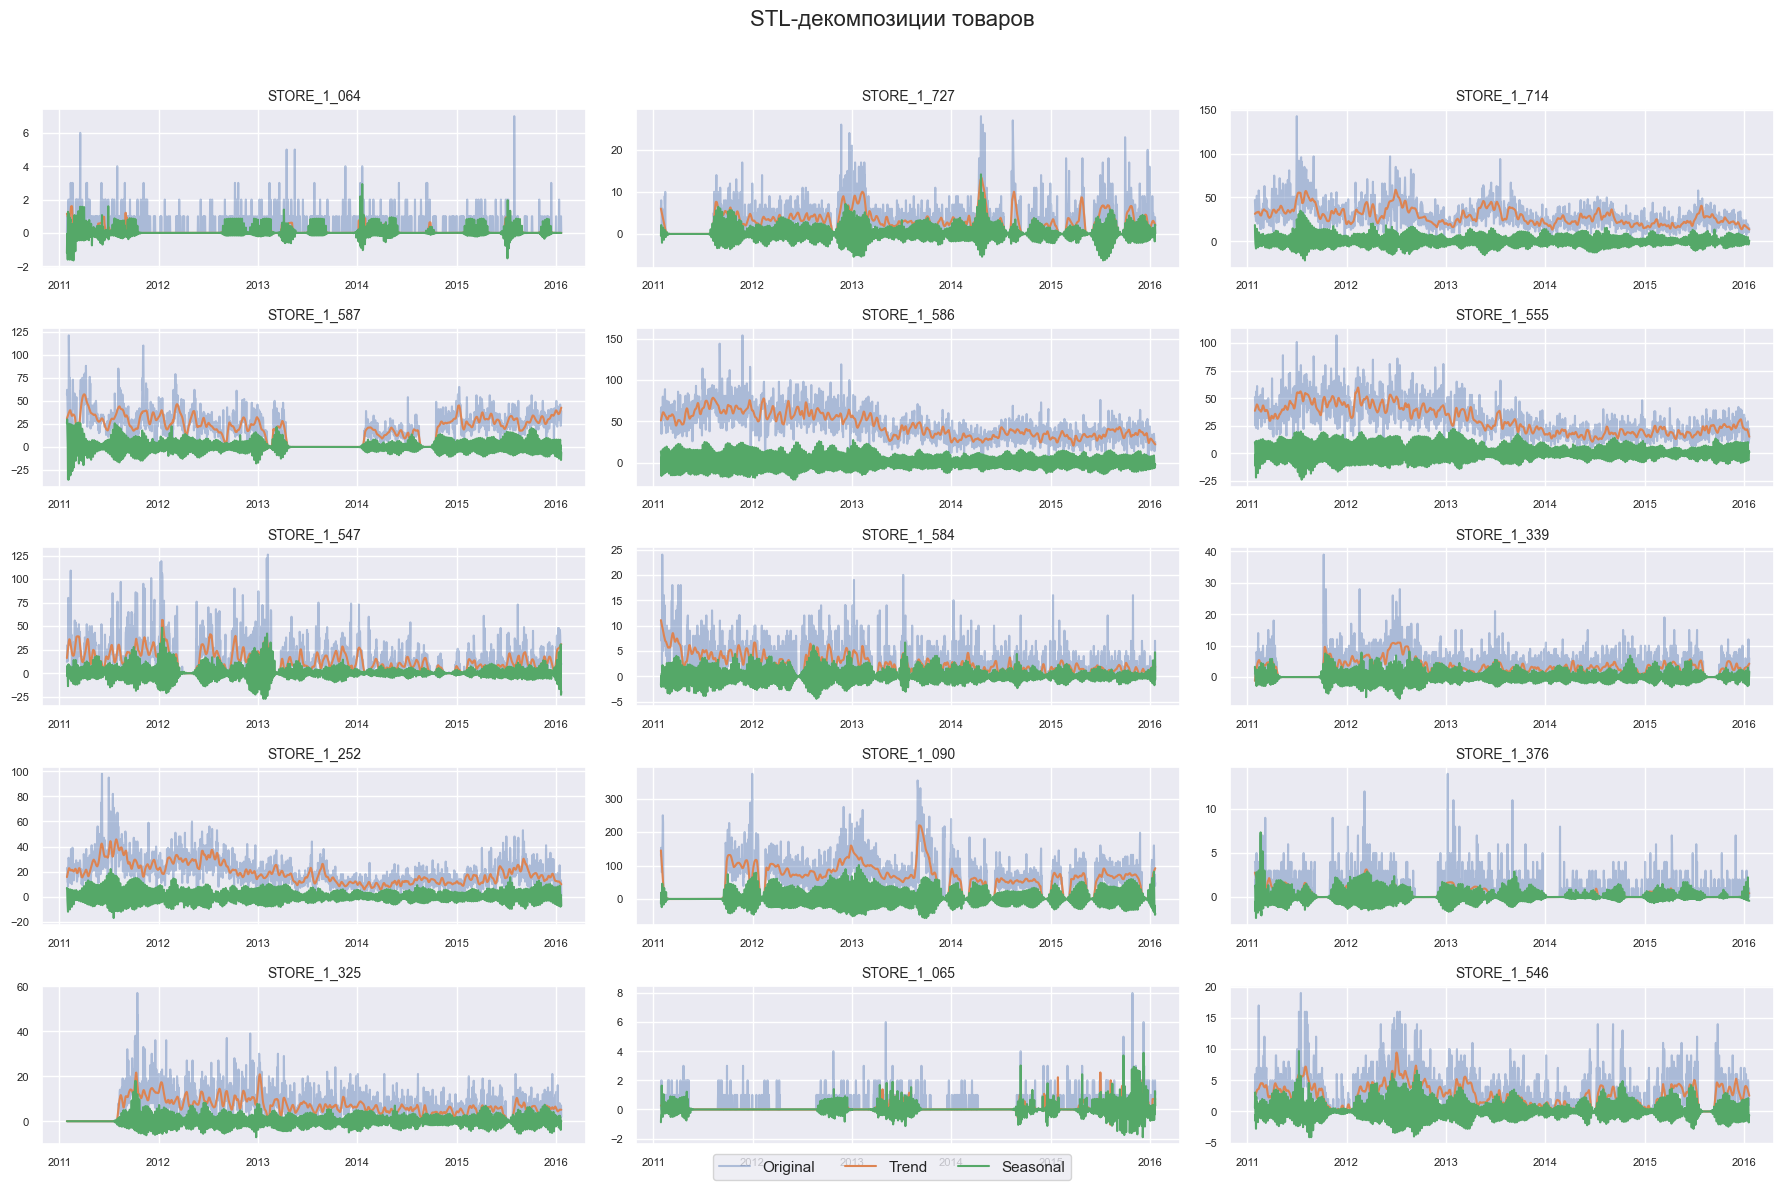

In [16]:
item_ids = df['item_id'].unique()

fig, axes = plt.subplots(5, 3, figsize=(18, 12))  # 5 строк, 3 столбца
axes = axes.flatten()

for idx, item_id in enumerate(item_ids):
    df_item = df[df['item_id'] == item_id].sort_values('date')

    if len(df_item) < 14:
        axes[idx].set_title(f'{item_id}\nНедостаточно данных')
        axes[idx].axis('off')
        continue

    stl = STL(df_item['cnt'], period=7, robust=True)
    result = stl.fit()

    axes[idx].plot(df_item['date'], df_item['cnt'], label='Original', alpha=0.4)
    axes[idx].plot(df_item['date'], result.trend, label='Trend')
    axes[idx].plot(df_item['date'], result.seasonal, label='Seasonal')
    axes[idx].set_title(f'{item_id}', fontsize=10)
    axes[idx].tick_params(labelsize=8)

for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle('STL-декомпозиции товаров', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])  # type: ignore
fig.legend(['Original', 'Trend', 'Seasonal'], loc='lower center', ncol=3)
plt.show()

## Корреляция между артикулами

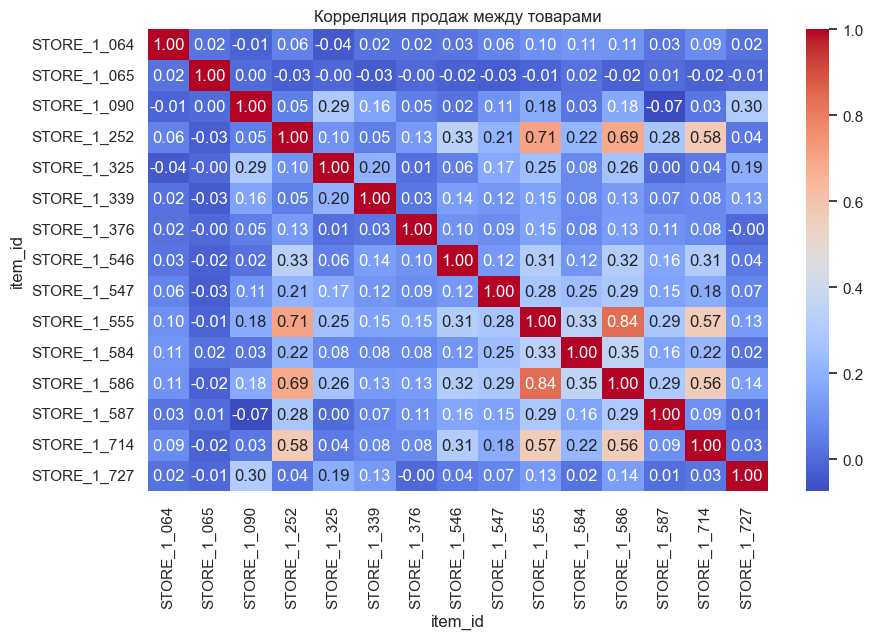

In [17]:
df_corr = df.groupby(['date', 'item_id'])['cnt'].sum().reset_index()
df_pivot = df_corr.pivot(index='date', columns='item_id', values='cnt')
corr_matrix = df_pivot.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция продаж между товарами')
plt.show()

## Поиск выбросов в продажах

Всего выбросов: 355


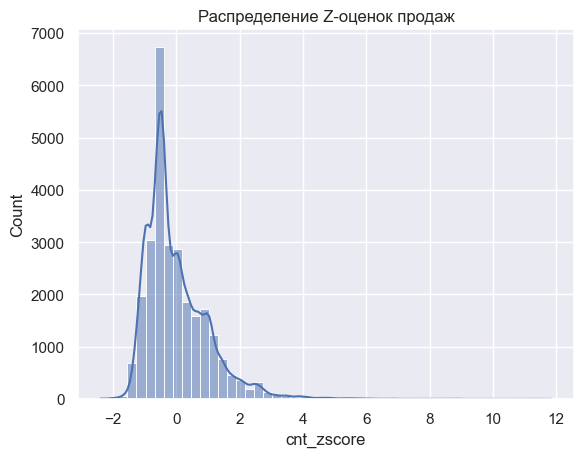

In [18]:
df['cnt_zscore'] = df.groupby('item_id')['cnt'].transform(zscore)

# считаем выбросами значения с |z-score| > 3
outliers = df[abs(df['cnt_zscore']) > 3]

print(f'Всего выбросов: {outliers.shape[0]}')
sns.histplot(df['cnt_zscore'], bins=50, kde=True)  # type: ignore
plt.title('Распределение Z-оценок продаж')
plt.show()

## Влияние праздников на продажи

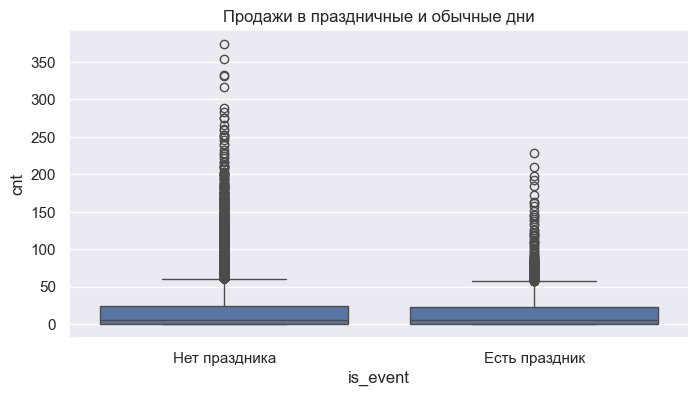

In [19]:
df['is_event'] = (
    df['type_National']
    + df['type_Religious']
    + df['type_Sporting']
    + df['type_Cultural']
) > 0

plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='is_event', y='cnt')
plt.xticks([0, 1], ['Нет праздника', 'Есть праздник'])
plt.title('Продажи в праздничные и обычные дни')
plt.show()